In [11]:
import networkx as nx
import numpy as np
from tqdm import tqdm_notebook
from scipy.spatial import distance
import pandas as pd

In [2]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 10000)

In [51]:
nr_nodes = 200

#G = nx.watts_strogatz_graph(nr_nodes, 10, 0.1, seed=42)
G = nx.barabasi_albert_graph(nr_nodes, m=2)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

In [52]:
def propag_emb(G, nr_nodes, nr_topics, steps, perc_influencers, seed=42):
    '''
    generates interests with the propagation method starting from "n" nodes
    '''
    numb_influencers = int(perc_influencers/100 * nr_nodes)
    
    # INITIALIZE
    np.random.seed(seed)
    for i in list(G.nodes):
        interests = np.random.dirichlet(np.ones(nr_topics)*1./nr_topics)
        G.nodes[i]['interests'] = interests
    
    # SELECT INFLUENCERS
    # start with a random node
    influencers = [np.random.choice(G.nodes)]

    for i in range(numb_influencers):
        # calculate distances to current influencers
        sp = {i: nx.shortest_path(G, i) for i in influencers}
        distances = np.array([list(len(sp[j][i]) for j in influencers) for i in G.nodes()])
        # select the node fartest from all influencers
        influencers.append(distances.min(axis=1).argmax()) 
      
    # PROPAGATION STEP
    for c in range(steps):
        i = np.random.choice(nr_nodes)
        interests_i = G.nodes[i]['interests']
        #print(G.nodes[0]['interests'])
        lr = 0.5 if i in influencers else 0.01
        #lr = 0.1
        for j in list(G.neighbors(i)):
            if j in influencers:
                continue
            interests_j = G.nodes[j]['interests']
            interests_j += interests_i * lr
            interests_j /= interests_j.sum()
            G.nodes[j]['interests'] = interests_j
            #print(interests_j)
        

    # preparing matrix
    prop_emb = [G.nodes[_]['interests'] for _ in range(nr_nodes)]
    return np.array(prop_emb)

In [158]:
dimensions = [10]
steps = [10**i for i in range(0, 7)]
percentages = [2**i*100 for i in range(-8, 0)]

In [159]:
args_list = []

nr_experiments = 10

for d in dimensions:
    for s in steps:
        for p in percentages:
            for seed in range(nr_experiments):
                args = [d, s, p, seed]
                args_list.append(args)

In [160]:
def run_experiment(*args):
    d, s, p, seed = args
    G_emb =  propag_emb(G, nr_nodes, nr_topics=d, 
                        steps=s, perc_influencers=p,
                        seed=seed+int(1000*(p)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    return args + (si/so,)

In [161]:
%%time
result = list(map(lambda x: run_experiment(*x), args_list))

CPU times: user 1h 51min 6s, sys: 6.17 s, total: 1h 51min 12s
Wall time: 1h 51min 18s


In [162]:
df = pd.DataFrame(result, columns=['d', 'steps', 'influencers fraction', 'seed', 'hom'])
df.head()

,d,steps,influencers fraction,seed,hom
0,10,1,0.390625,0,1.047719
1,10,1,0.390625,1,0.958530
2,10,1,0.390625,2,0.942143
3,10,1,0.390625,3,1.015940
4,10,1,0.390625,4,1.022035


In [163]:
df2 = df.groupby(['steps', 'influencers fraction'])['hom'].mean().unstack()

In [164]:
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


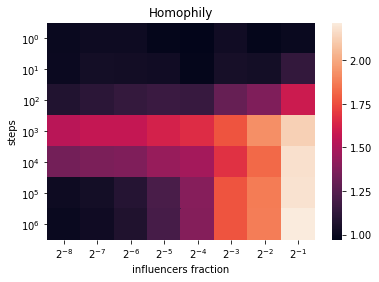

In [170]:
pp = sns.heatmap(df2)
pp.axes.set_xticklabels(["$2^{%d}$" % i for i in range(-8, 0)])
pp.axes.set_yticklabels(["$10^{%d}$" % i for i in range(0, 7)])
plt.xticks(rotation=360)
plt.yticks(rotation=-360)
plt.title('Homophily')
plt.savefig('Plots/heatmap_prop.pdf')

In [113]:
[u"$2^{}$".format(x) for x in range(3, 11)]

['$2^3$', '$2^4$', '$2^5$', '$2^6$', '$2^7$', '$2^8$', '$2^9$', '$2^10$']

In [173]:
pow(2,-8)*100

0.390625